# Algorithmic Trading

**Installing Libraries**

In [1]:
#!pip install tabulate
#!pip install iexfinance
#!pip install datetime

#### Import packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import pandas as pd
import seaborn as sns # for making plots with seaborn
color = sns.color_palette()
import sklearn.metrics as metrics
from scipy.stats import norm 
from tabulate import tabulate

from iexfinance.stocks import get_historical_data
from iexfinance.stocks import Stock
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

#### Importing the dataset

In [3]:
stock_prices = pd.read_csv('ICICIBANK.NS.csv')

#Glimpse of Data
stock_prices.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-07-21,299.500000,303.899994,296.200012,302.049988,297.381653,9705981
1,2017-07-24,302.200012,306.600006,301.600006,303.049988,298.366211,15604131
2,2017-07-25,306.799988,306.799988,301.799988,304.149994,299.449188,18129742
3,2017-07-26,306.799988,311.000000,304.549988,310.350006,305.553406,26050717
4,2017-07-27,314.450012,314.450012,305.350006,307.200012,302.452087,28535869


#### Fixing messy column names (containing spaces) for ease of use

In [4]:
stock_prices.columns = stock_prices.columns.str.replace(' ', '_')

In [5]:
stock_prices.head()

,Date,Open,High,Low,Close,Adj_Close,Volume
0,2017-07-21,299.500000,303.899994,296.200012,302.049988,297.381653,9705981
1,2017-07-24,302.200012,306.600006,301.600006,303.049988,298.366211,15604131
2,2017-07-25,306.799988,306.799988,301.799988,304.149994,299.449188,18129742
3,2017-07-26,306.799988,311.000000,304.549988,310.350006,305.553406,26050717
4,2017-07-27,314.450012,314.450012,305.350006,307.200012,302.452087,28535869


#### First, let us check the number of rows (observations) and the number of columns (variables)

In [6]:
print('The number of rows (observations) is',stock_prices.shape[0],'\n''The number of columns (variables) is',stock_prices.shape[1])

The number of rows (observations) is 492 
The number of columns (variables) is 7


#### Lets us plot & see price trend over time for different companies

Changing format of 'Date' variable from object to Datetime

In [7]:
stock_prices['Date'] = [pd.to_datetime(d) for d in stock_prices['Date']]

Text(0.5, 1.0, 'DIS Stock Price 1/1/17 - 8/1/19')

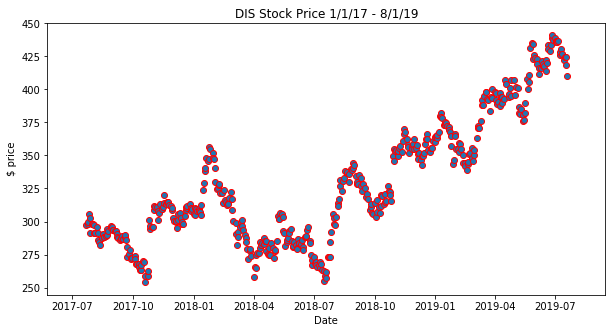

In [8]:
plt.figure(figsize=(10,5))
plt.scatter(stock_prices['Date'], stock_prices['Adj_Close'], edgecolors='r')
#plt.plot(stock_prices.index, stock_prices['Adj_Close'])
plt.xlabel("Date")
plt.ylabel("$ price")
plt.title("DIS Stock Price 1/1/17 - 8/1/19")

# Generating technical indicators of the stock###

#### ## Implementing moving average

In [9]:
stock_prices["average10"] = stock_prices['Adj_Close'].rolling(window=10).mean()
stock_prices["average20"] = stock_prices['Adj_Close'].rolling(window=20).mean()
stock_prices["average10"].head(20)

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
5            NaN
6            NaN
7            NaN
8            NaN
9     297.893631
10    297.322598
11    297.037079
12    296.185449
13    294.240973
14    292.424484
15    291.518708
16    290.455402
17    289.702225
18    288.845667
19    288.594605
Name: average10, dtype: float64

In [10]:
stock_prices["std10"] = stock_prices['Adj_Close'].rolling(window=10).std()
stock_prices["std20"] = stock_prices['Adj_Close'].rolling(window=20).std()

#### Computing RSI Indicator
Relative Strength Index (RSI) - The Relative Strength Index (RSI) calculates a ratio of the recent upward price movements to the absolute price movement. The RSI ranges from 0 to 100. The RSI is interpreted as an overbought/oversold indicator when the value is over 70/below 30.

In [11]:
def RSI (data, time_window):
    diff = data.diff(1).dropna()        # diff in one field(one day)

    #this preservers dimensions of diff values
    up_chg = 0 * diff
    down_chg = 0 * diff
    
    # up change is equal to the positive difference, otherwise equal to zero
    up_chg[diff > 0] = diff[ diff>0 ]
    
    # down change is equal to negative deifference, otherwise equal to zero
    down_chg[diff < 0] = diff[ diff < 0 ]
    
    up_chg_avg   = up_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    down_chg_avg = down_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    
    rs = abs(up_chg_avg/down_chg_avg)
    rsi = 100 - 100/(1+rs)
    return rsi

In [12]:
stock_prices['rsi5'] = RSI(stock_prices['Adj_Close'], 5)
stock_prices['rsi14'] = RSI(stock_prices['Adj_Close'], 14)

#### Calculating MACD (Moving Average Convergence Divergence) 
MACD is the difference between two Exponential Moving Averages

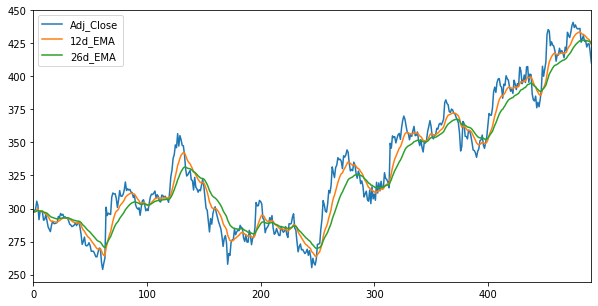

In [13]:
stock_prices['12d_EMA'] = stock_prices['Adj_Close'].ewm(span=12, adjust=False).mean()
stock_prices['26d_EMA'] = stock_prices['Adj_Close'].ewm(span=26, adjust=False).mean()

stock_prices[['Adj_Close','12d_EMA','26d_EMA']].plot(figsize=(10,5))
plt.show()

#### Calculate the difference between 26 day & 12 day Moving averages

In [14]:
stock_prices['macd'] = stock_prices['12d_EMA'] - stock_prices['26d_EMA'] 

#### Calculate Signal

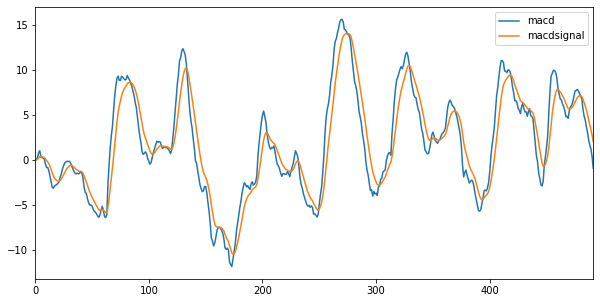

In [15]:
stock_prices['macdsignal'] = stock_prices.macd.ewm(span=9, adjust=False).mean()

stock_prices[['macd','macdsignal']].plot(figsize=(10,5))
plt.show()

#### Compute the Bollinger Bands using the 20-day Moving average

In [16]:
MA = stock_prices['Adj_Close'].rolling(window=20).mean()
SD = stock_prices['Adj_Close'].rolling(window=20).std()
stock_prices['UpperBB'] = MA + (2 * SD) 
stock_prices['LowerBB'] = MA - (2 * SD)

## Steps: We clean the output and generated a column called direction basis the following:
- If Price > upper Bollinger band, and MACD value > MACD signal -> Buy signal (1)
- If Price < lower Bollinger band, and MACD value < MACD signal -> Sell signal (-1)
- Else, Out of the market -> Signal OOM(0)

In [17]:
# Define Signal
stock_prices['Direction'] = np.where((stock_prices['macd'] > stock_prices['macdsignal']) & 
                                      (stock_prices['Adj_Close'] > stock_prices['UpperBB']), 1, 
                                     np.where((stock_prices['macd'] < stock_prices['macdsignal']) & 
                                               (stock_prices['Adj_Close'] < stock_prices['LowerBB']),-1,0))



stock_prices['Direction']

0      0
1      0
2      0
3      0
4      0
      ..
487    0
488    0
489    0
490    0
491   -1
Name: Direction, Length: 492, dtype: int64

#### Checking distribution of response variable

In [18]:
stock_prices['Direction'].value_counts()

 0    439
 1     34
-1     19
Name: Direction, dtype: int64

#### Create the plot

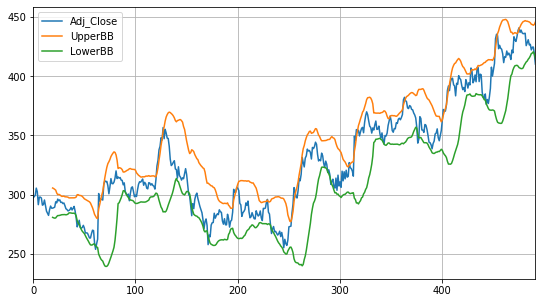

In [19]:
pd.concat([stock_prices.Adj_Close,stock_prices.UpperBB,stock_prices.LowerBB],axis=1).plot(figsize=(9,5),grid=True)

In [20]:
ICICI_final = stock_prices[['Adj_Close','average10', 'average20', 'std10', 'std20', 'rsi5', 'rsi14', 'Direction']]

#### Creating training & test datasets for model building

In [21]:
X = ICICI_final.drop(['Direction'], axis=1)
y = ICICI_final['Direction']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=142,stratify=ICICI_final['Direction'])
                                             
Train_icici = pd.concat([X_train,y_train], axis=1)
Test_icici = pd.concat([X_test,y_test], axis=1)

#Exporting training & test dataset
Train_icici.to_csv('Train_icici.csv',index=False)
Test_icici.to_csv('Test_icici.csv',index=False)

#### Importing training & test datasets

In [22]:
Train_icici = pd.read_csv('Train_icici.csv')
Test_icici = pd.read_csv('Test_icici.csv')

#### Checking frequency of response variables

In [23]:
ICICI_final['Direction'].value_counts()

 0    439
 1     34
-1     19
Name: Direction, dtype: int64

In [24]:
Train_icici['Direction'].value_counts()

 0    307
 1     24
-1     13
Name: Direction, dtype: int64

In [25]:
Test_icici['Direction'].value_counts()

 0    132
 1     10
-1      6
Name: Direction, dtype: int64

# Model building:
We choose to model this data using Decision Trees such as CART & RandomForest. 

Decision Trees are simple yet powerful and require minimal data preparation such as scaling and missing value treatment etc.

Here, Before we proceed for model building, lets do missing value imputation (Scaling is not required while modelling trees)

In [26]:
#creating list of columns in the dataset
col_train=list(Train_icici)
col_test=list(Test_icici)

from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='median')

Train_icici = pd.DataFrame(imputer.fit_transform(Train_icici))
Test_icici = pd.DataFrame(imputer.fit_transform(Test_icici))

Train_icici.columns=col_train
Test_icici.columns=col_test

Train_icici.head()

,Adj_Close,average10,average20,std10,std20,rsi5,rsi14,Direction
0,430.899994,434.760004,430.352501,4.764853,7.955791,45.262436,53.884124,0.0
1,280.349030,282.810404,284.703186,2.524339,4.294641,39.245439,44.801678,0.0
2,357.200012,369.814999,370.162500,5.508833,6.990647,10.803827,38.842965,0.0
3,322.000000,318.715002,314.107501,4.803704,6.454789,56.506258,52.936312,0.0
4,262.331909,265.231355,272.704053,4.182059,10.928479,43.663939,40.282918,0.0


In [27]:
X_train = Train_icici.drop(['Direction'], axis=1)
y_train = Train_icici['Direction']

X_test = Test_icici.drop(['Direction'], axis=1)
y_test = Test_icici['Direction']

## Import CART model

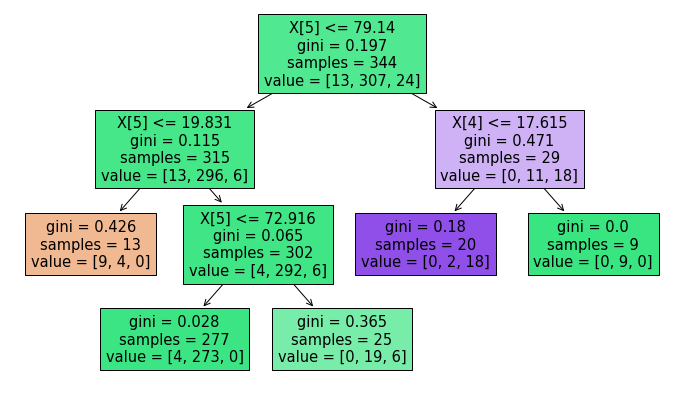

In [28]:
#Visualising Dtree in Python
from sklearn import tree
import matplotlib.pyplot as plt
clf = tree.DecisionTreeClassifier(max_leaf_nodes = 5)
plt.figure(figsize=(12,7))
tree.plot_tree(clf.fit(X_train, y_train),filled=True)
plt.show()

#### Fit CART model

In [29]:
clf = clf.fit(X_train, y_train)

#### Predict on training & test datasets

In [30]:
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

model_score_train = clf.score(X_train, y_train)
model_score_test = clf.score(X_test, y_test)

##### Confusion matrix report

In [31]:
print(metrics.classification_report(y_train,y_pred_train,digits=3))
print(metrics.classification_report(y_test,y_pred_test,digits=3))

              precision    recall  f1-score   support

        -1.0      0.692     0.692     0.692        13
         0.0      0.968     0.980     0.974       307
         1.0      0.900     0.750     0.818        24

    accuracy                          0.953       344
   macro avg      0.853     0.808     0.828       344
weighted avg      0.953     0.953     0.953       344

              precision    recall  f1-score   support

        -1.0      0.333     0.500     0.400         6
         0.0      0.955     0.955     0.955       132
         1.0      1.000     0.700     0.824        10

    accuracy                          0.919       148
   macro avg      0.763     0.718     0.726       148
weighted avg      0.932     0.919     0.923       148



***Observation***: While model is able to identify the Buy and OOM signals, it is not able to identify the Sell signals correctly

### Import Random Forest Model

In [32]:
from sklearn.ensemble import RandomForestClassifier
#Create a Gaussian Classifier
clfRF=RandomForestClassifier(n_estimators=100, max_leaf_nodes = 5)

#### Fit RF model

In [33]:
clfRF.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=5, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

#### Predict on training & test datasets

In [34]:
y_pred_train = clfRF.predict(X_train)
y_pred_test = clfRF.predict(X_test)

RFmodel_score_train = clfRF.score(X_train, y_train)
RFmodel_score_test = clfRF.score(X_test, y_test)

#### Classification report

In [35]:
print(metrics.classification_report(y_train,y_pred_train,digits=3))
print(metrics.classification_report(y_test,y_pred_test,digits=3))

              precision    recall  f1-score   support

        -1.0      0.000     0.000     0.000        13
         0.0      0.927     1.000     0.962       307
         1.0      1.000     0.542     0.703        24

    accuracy                          0.930       344
   macro avg      0.642     0.514     0.555       344
weighted avg      0.898     0.930     0.908       344

              precision    recall  f1-score   support

        -1.0      0.000     0.000     0.000         6
         0.0      0.904     1.000     0.950       132
         1.0      1.000     0.200     0.333        10

    accuracy                          0.905       148
   macro avg      0.635     0.400     0.428       148
weighted avg      0.874     0.905     0.869       148



***Observation***: While model is able to identify the Buy and OOM signals, it is not able to identify the Sell signals correctly

Both the models: Decision tree (CART) & RandomForest can be further improved using hyperparameter tuning or using advanced algorithm such as Boosting techniques

# End